In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# 1- Objective

Digit recognition is essential for enabling machines to interpret handwritten or printed numbers, improving efficiency in fields like finance and healthcare. Machine learning models, such as Convolutional Neural Networks (CNNs), are particularly effective for this task due to their ability to detect spatial patterns in images. However, in this work we try to use a more novel clustering approach and explore the limitations of it.

# 2- Dataset

The famous MNIST dataset is used here. MNIST is a subset of a larger set available from NIST (it's copied from http://yann.lecun.com/exdb/mnist/).
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.

In [56]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

Each row of the data represents the values in each pixel of 28x28 image. As you can see there are about equal number of training datapoints for each label (number).

Text(0.5, 0, 'Number')

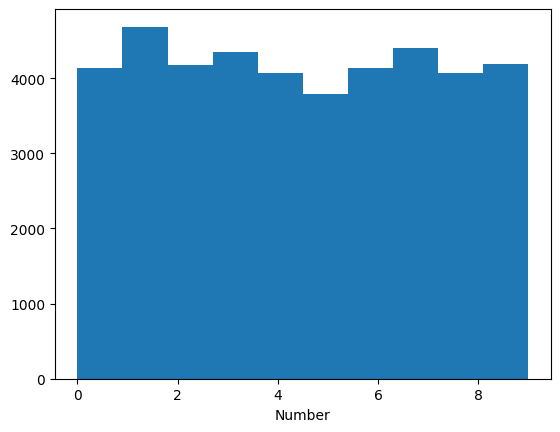

In [57]:
plt.hist(train.label);
plt.xlabel('Number')

Let's try to visualize a sample image.

In [58]:
def plot_image(image_1d):
    plt.imshow(image_1d.values.reshape(28,28))

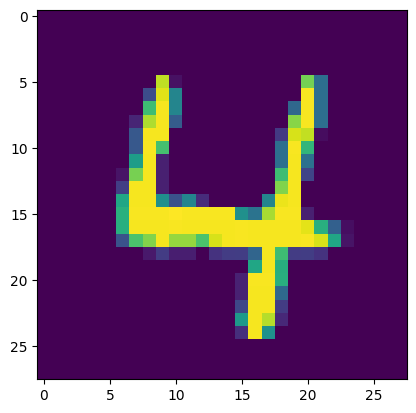

In [59]:
plot_image(train.iloc[42,1:])

# 3- Data Preparation
## 3-1- Normalization
Let's start by normalizing the data based on the largest value:

In [115]:
def norm_half(x):
    return(x/255)

train_pix_01 = train.iloc[:,1:].applymap(norm_half); #these are pixel values between 0 and 1

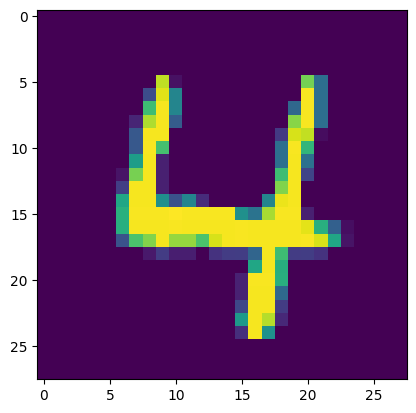

In [61]:
plot_image(train_pix_01.iloc[42,:])

## 3-2- Train Test Split

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_pix_01,
                                                   train.label,random_state = 42)

# 4- Clustering
Here we try two different clustering methods for categorizing different digits:
- KMeans
- Agglomerative Clustering

## 4-1- KMeans
We start by the KMeans algorithm. Since we know that we have 10 digits, we can start by setting 10 for the number of clusters.

In [64]:
from sklearn.cluster import KMeans

In [101]:
km = KMeans(n_clusters =10, random_state = 42)

In [116]:
km.fit(X_train)

KMeans(n_clusters=18, random_state=42)

Now, we have to look at our clusters. We plot each cluster and also a histogram of the labels used in each of them.

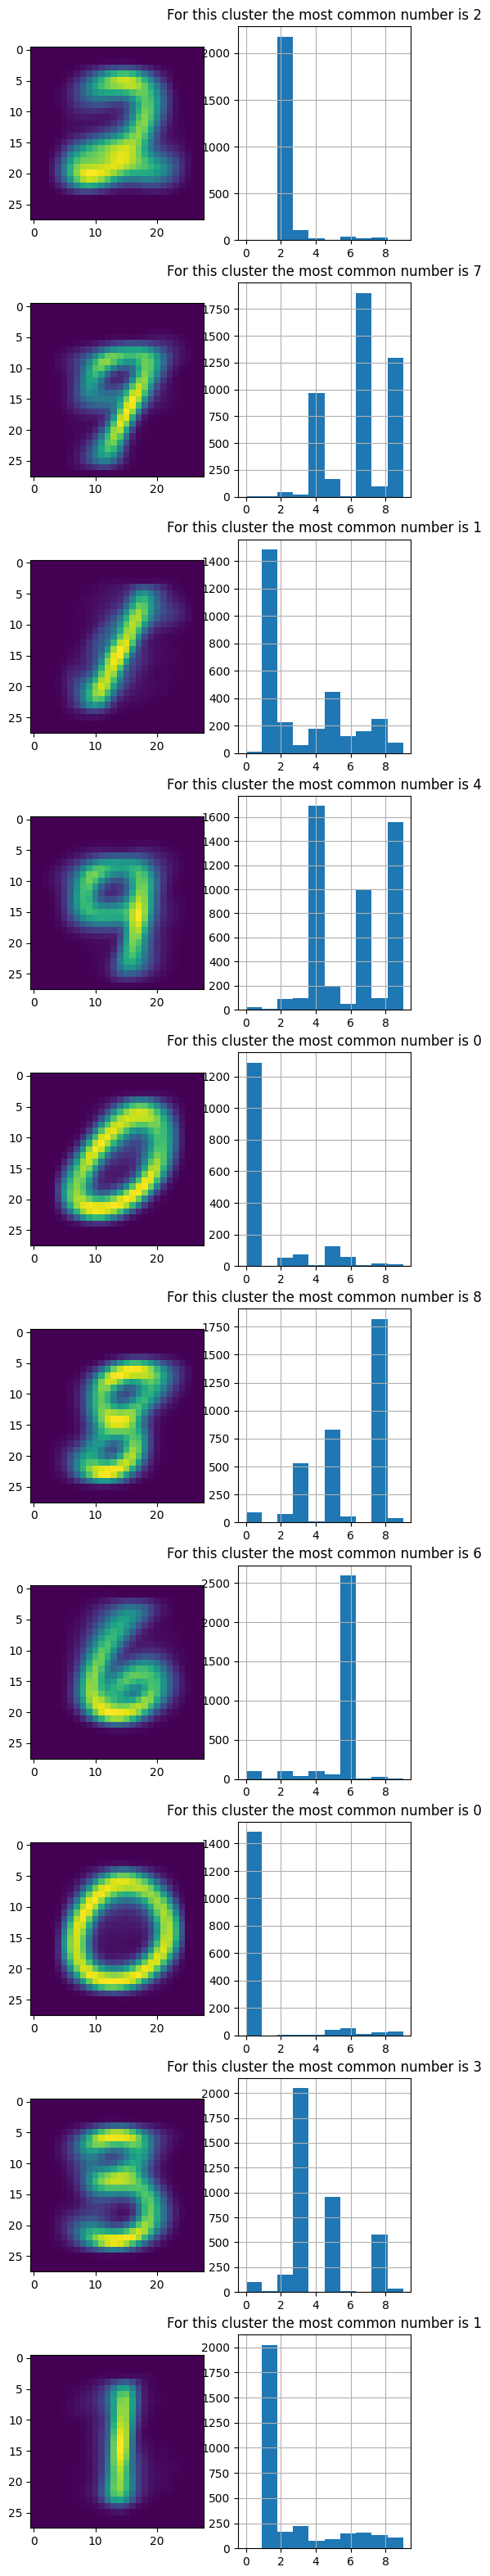

In [68]:
# Create subplots
fig, axes = plt.subplots(10, 2, figsize=(6, 40))  # 2 rows, 2 columns

for i in range(10):
    axes[i][0].imshow(X_train[km.labels_ == i].mean().values.reshape(28,28))
    y_train[km.labels_ == i].hist( ax = axes[i][1])
    axes[i][1].set_title('For this cluster the most common number is ' +
                 str (y_train[km.labels_ == i].mode().values[0]))

It looks like the clustering algorithm does a good job for clustering numbers 2, 1, 0, and 6. It does worse for numbers 3, 4, 8, and 7 and there is no cluster with majority labels of 9 and 5.
Maybe we can improve it by increasing the number of clusters using some inertia L plots to find the best number of K.

In [117]:
km_list = list()

for clust in range(1,32,4):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(X_train)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

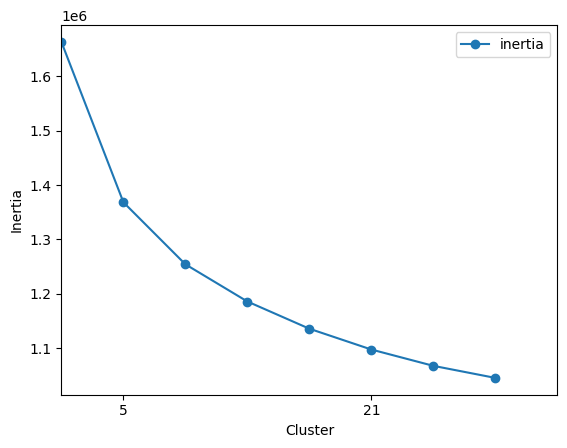

In [39]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(1,32,4))
ax.set_xlim(0,8)
ax.set(xlabel='Cluster', ylabel='Inertia');

The inertial plot does not look as helpful as we wanted. There is no sudden drop. Let's just try a larger K than 10 and see what happens:

In [121]:
km = KMeans(n_clusters =18, random_state = 42)
km.fit(X_train);

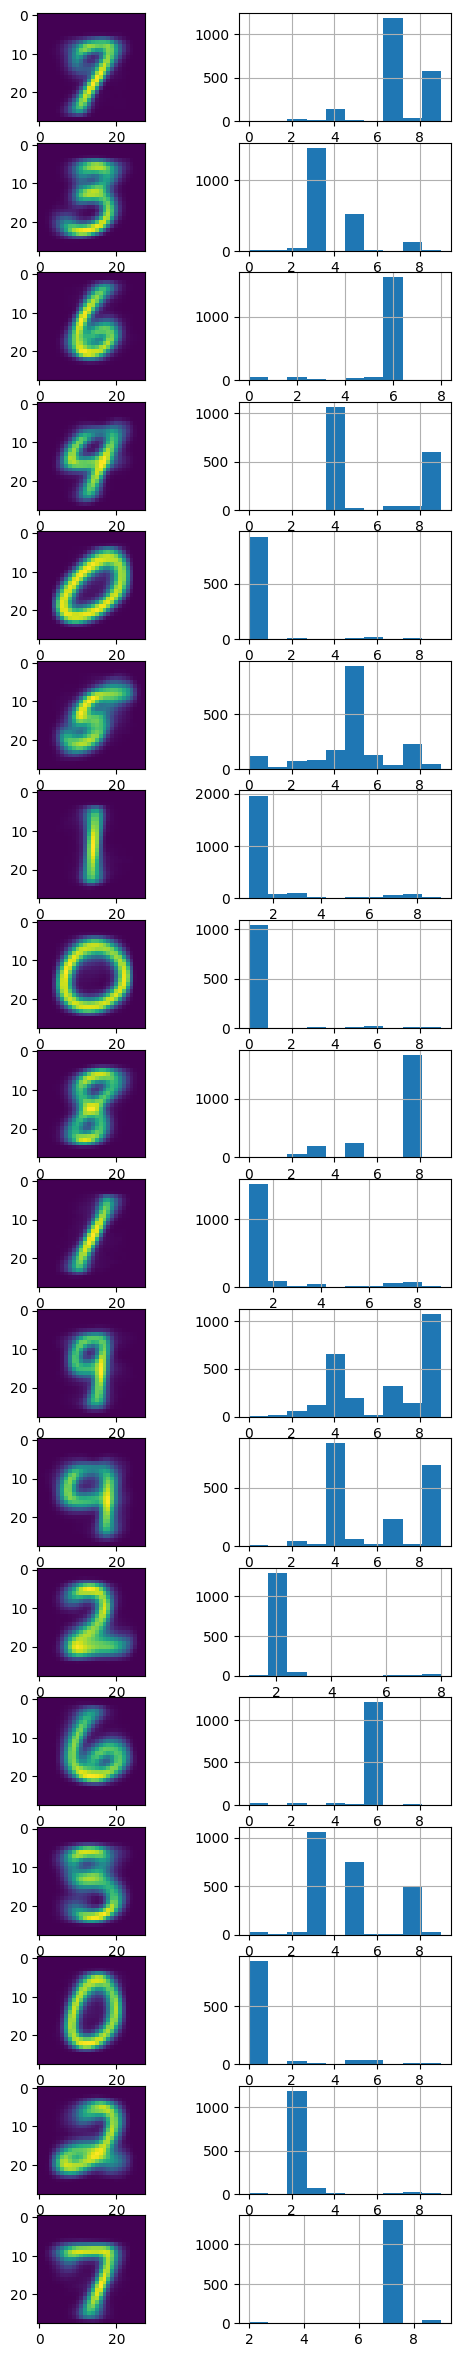

In [51]:
# Create subplots
fig, axes = plt.subplots(18, 2, figsize=(6, 30))  # 2 rows, 2 columns

# Flatten axes array for easy iteration
#axes = axes.flatten()

for i in range(18):
    axes[i][0].imshow(X_train[km.labels_ == i].mean().values.reshape(28,28))
    y_train[km.labels_ == i].hist( ax = axes[i][1])
    #axes[i][1].set_title('For this cluster the most common number is ' +
               #  str (y_train[km.labels_ == i].mode().values[0]))

This looks like it is doing a better job. However, we there are still issues for detection between.
We'll stop here as more investigation is outside the scope here. 

## 4-2- Hierarchical Clustering

We can use Agglomerative Clustering as the second method here. One issue is that this type of clustering is slow so we are not going to try different K's. Let's just use the K from previous part.

In [91]:
from sklearn.cluster import AgglomerativeClustering
### BEGIN SOLUTION
ag = AgglomerativeClustering(n_clusters=18, linkage='ward', compute_full_tree=True)
ag.fit(X_train)

AgglomerativeClustering(compute_full_tree=True, n_clusters=18)

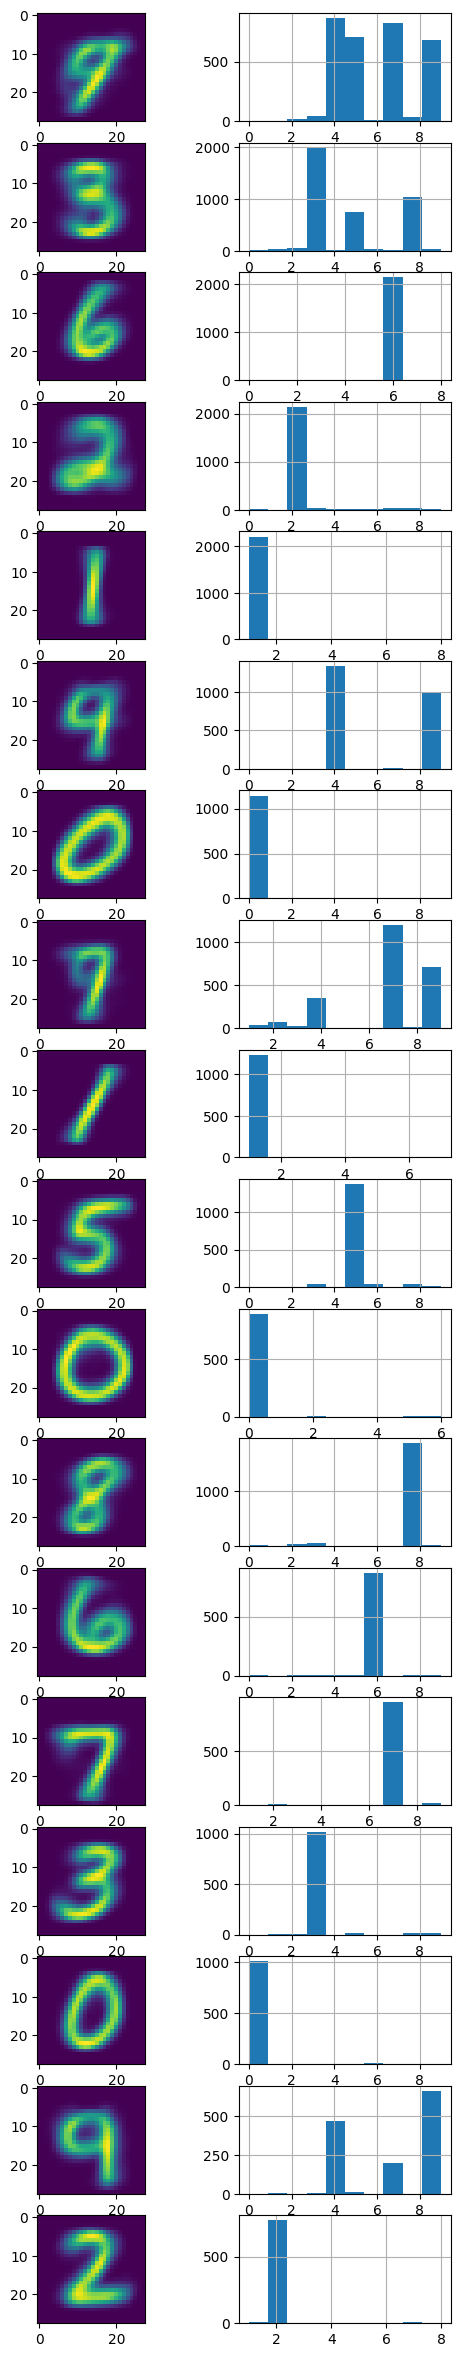

In [87]:
# Create subplots
fig, axes = plt.subplots(18, 2, figsize=(6, 30))  # 2 rows, 2 columns

for i in range(18):
    axes[i][0].imshow(X_train[ag.labels_ == i].mean().values.reshape(28,28))
    y_train[ag.labels_ == i].hist( ax = axes[i][1])

# 4- Performance

We usually compare the performance of two models by checking the test set. Unfortunately, we cannot do the same for the hierarchical clustering algorithm since it cannot predict labels for new observations. So we compare the results of two algorithm for the train set and also compute the performance of KMeans in the test set sepearately  Let's assign the most common number to each label.  

## 4-1- Comparision
We use accuracy score for comparing the models.

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
y_pred_train_km = [y_train[km.labels_ == x].mode()[0] for x in km.labels_]
y_pred_train_ag = [y_train[ag.labels_ == x].mode()[0] for x in ag.labels_]

In [108]:
#KMeansClustering
accuracy_score(y_train,y_pred_train_km)

0.7082222222222222

In [97]:
#AgglomerativeClustering
accuracy_score(y_train,y_pred_train_ag)

0.7505079365079365

We can see that the Agglomerative Clustering is doing a better job. However, this method lacks prediction capablities that we need for such a problem.

In [88]:
km_results = km.predict(X_test)
y_pred_km = [y_train[km.labels_ == x].mode()[0] for x in km_results]

## 4-2- Test Set Performance

In [103]:
km_results = km.predict(X_test)
y_pred_km = [y_train[km.labels_ == x].mode()[0] for x in km_results]

In [105]:
#KMeansClustering
accuracy_score(y_test,y_pred_km)

0.7144761904761905

The performance on the test set is very similar to the train set which shows consistency in our modeling.

# 6- Submission

In [122]:
test_pix_01 = test.applymap(norm_half); #these are pixel values between 0 and 1


In [123]:
km_results = km.predict(test_pix_01)
y_pred_km = [y_train[km.labels_ == x].mode()[0] for x in km_results]

In [127]:
submission_df = pd.DataFrame({
    "ImageId": np.arange(1, len(y_pred_km) + 1),
    "Label": y_pred_km
})

In [126]:
submission_df.to_csv("submission.csv", index=False)

# 7- Findings and Flaws

In this work we used clustering algorithms to predict MNIST digit recognition. The Agglomerative clustering had better performance but lacks the capablity to predict new observations. The KMeans model had an accuracy of 0.7 for both training and testing sets. 

The main flaw of this work is that while clustering can provide some interesting insights, it is not a proper algorithm for digit recognition.

Both of the algorithm struggle with some of the numbers (e.g. 4 and 9) due to similarity. The performance of both algorithm is far below simple Neural Network solutions for this problem.